# Install Independences

In [32]:
# FOR SPLITTING DATASET
# Import os to move, modify and create directory for training set and test set
import os
# Import random to generate randomicaly a number
import random
# Import shutil to move the image 
import shutil

# FOR DATA LOADER 
from tensorflow import keras
from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# FOR AUXILIARY FUNCTION OF NEURAL NETWORK

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import cv2

# FOR MODELS NEURAL NETWORK
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.backend import clear_session, reset_uids

# FOR TRAINING 
from keras.utils import plot_model
import visualkeras


In [2]:
from tensorflow.config.experimental import list_physical_devices, set_memory_growth
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus =list_physical_devices('GPU')
for gpu in gpus: 
    set_memory_growth(gpu, True)

In [3]:
list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Pre-Processing Data: Splitting 

In [4]:
#creating test dataset from the training set
def create_ValidationSet(data_path):
    
    # creating train directory 
    train_dir = data_path+"/Pokemon_train"
    os.system("mkdir " +train_dir)

    #moving all folders from root folder to train folder
    os.system("mv " + data_path+"/* " + train_dir+'/')

    val_dir = data_path+"/Pokemon_validation"
    os.system("mkdir " +val_dir)

    #copying all train data to test folder, in order to get same folder structure
    os.system("cp -r "+ train_dir+ "/* " + val_dir+'/')
    #deleting images from sub directories of test folder
    os.system("find " + val_dir + "/ -name '*.*' -type f -delete")

    return "Done we split the dataset into training set and validation set"


# Copying 15 random images from train folders to test folders
def prep_test_data(pokemon, train_dir, test_dir):
  pop = os.listdir(train_dir+'/'+pokemon)
  test_data=random.sample(pop, 15)
  for f in test_data:
    shutil.copy(train_dir+'/'+pokemon+'/'+f, test_dir+'/'+pokemon+'/')

def loop_prep(train_dir, test_dir):
  #performing samething for each folder in train folder
  for poke in os.listdir(train_dir):
    prep_test_data(poke, train_dir, test_dir)

In [6]:
# UN ALTRO MODO è FARE LO SPLITTING DEL 20%
def create_path(path):
  train_dir = path+"/Pokemon_train"
  test_dir =  path+"/Pokemon_test"
  os.system("mkdir " +train_dir)
  os.system("mkdir " +test_dir)
  return train_dir, test_dir

def splitting(data_path, train_path, test_path, perc):
  
  # folders Pokemon
  fold = sorted(os.listdir(data_path))
  for f in fold:
    # Take the pokemon directory by data_path
    pok_dir = data_path+ f + '/'

    # CREATE POKEMON FOLDER IN THE TEST SET
    if not os.path.isdir(test_path+f):
      os.makedirs(test_path+f)
    pok_file = os.listdir(data_path+f) # list with image of pokemon
  
    # Number of pokemon for the test set
    num_test = round(len(pok_file)* perc)
    # select randomly the image of pokemon for the test set
    img_pok_test = random.sample(pok_file, num_test)

    # We move the image into test set
    for pok_test in img_pok_test:
      shutil.move(pok_dir + pok_test, test_path + f + '/'+ pok_test )

    # CREATE POKEMON FOLDER IN THE TRAIN SET
    if not os.path.isdir(train_path+f):
      os.makedirs(train_path+f)
    
    pok_file = os.listdir(data_path+f) # list with image of pokemon
    # We move the remaining image into train set
    for pok_train in pok_file:
      shutil.move(pok_dir+ pok_train, train_path+f+'/'+pok_train)
      
  return  "Done we split the dataset into training set and validation set"

# DataLoader

In [7]:
def data_load(train_dir, validation_dir, image_size, num_batch):
    # Process Data Augmentation
    datagen=ImageDataGenerator(rescale = 1./255,     # Rescaling factor
                               shear_range=0.2,      # Shear Intensity (Shear angle in counter-clockwise direction in degrees) 
                               zoom_range=0.2,       # Range for random zoom.
                               horizontal_flip=True) # Randomly flip inputs horizontally. 
    
    print('------ Loading TRAIN SET -------')
    training_set=datagen.flow_from_directory(train_dir,
                                         target_size=(image_size[0], image_size[1]),
                                         batch_size=num_batch,
                                         class_mode='categorical',
                                         color_mode='rgb')
    
    print('\n\n------ Loading VALIDATION SET ------')
    validation_set=datagen.flow_from_directory(validation_dir,
                                           target_size=(image_size[0], image_size[1]),
                                           batch_size=num_batch,
                                           class_mode='categorical',
                                           color_mode='rgb')
    return training_set, validation_set

# Auxiliary Functions

## Training

In [31]:
def train_model(model, train_set, val_set, early_stopping, pat, num_model, num_epochs):
    # Apply early stop --> to predict overfitting case
    es = None
    if early_stopping == True:
        es = EarlyStopping(monitor='val_loss',
                           mode='min', 
                           patience=pat,
                           restore_best_weights = True,
                           verbose=1
                           )
        # Create a File Pre trained
        filepath = "model"+str(num_model)+".h5"
        # Checkpoint of file
        ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        # Fit the model with respect to training and validation generator
        history = model.fit_generator(generator=train_set, 
                                      validation_data= val_set,
                                      callbacks=[es, ckpt],
                                      epochs = num_epochs)
        
    else:
        filepath = "model"+str(num_model)+".h5"
        # Checkpoint of file
        ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        # Fit the model with respect to training and validation generator
        history = model.fit_generator(generator=train_set, 
                                      validation_data= val_set,
                                      callbacks=[ckpt],
                                      epochs = num_epochs)

    return history, filepath, es

In [9]:
def eval_model(model, train_set , val_set):
    # Evaluate the Model
    metrics_train = model.evaluate(train_set)
    metrics_val = model.evaluate(val_set)

    print("Train Accuracy = %.4f - Train Loss = %.4f" % (metrics_train[1], metrics_train[0]))
    print("Test Accuracy = %.4f - Test Loss = %.4f" % (metrics_val[1], metrics_val[0]))

## Accuracy and Loss Functions

In [10]:
# Define Loss Functions
def loss_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Accuracy Function
def accuracy_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['acc'], color='teal', label='accuracy')
    plt.plot(hist.history['val_acc'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

def plot_history(hist):
    loss_function(hist)
    accuracy_function(hist)
    

## Make Prediction

In [11]:
def testing(model,
            train_set, 
            scale,
            test_file):
    
    # Dict with key: Number 
    #           value: Pokemon 
    diz={v:k for k,v in train_set.class_indices.items()}
   

    # Read file
    test_img = cv2.imread(test_file)
    # Resize the image testing with the input shape of neural network
    test_img = cv2.resize(test_img, scale)
    # 
    test_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    plt.imshow(test_img)

    #test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis=0)
    test_img = test_img/255
    #plt.imshow(test_img)

    if type(model) == str:
        model = load_model(model)
        prediction_prob = model.predict(test_img)
    else:
        prediction_prob = model.predict(test_img)
    classes_x=np.argmax(prediction_prob,axis=1)
    plt.title(diz[classes_x[0]])
    return diz[classes_x[0]]

# Models

## Model 1

Image with 64 x 64 x 3 

In [12]:
#%% ----- MODEL 1 -----
#defining model
def model_1(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return classifier


## Model 2

In [13]:
#%% ----- MODEL 2 -----
#Defining model
def model_2(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return classifier

# Training

## Training Model 1

In [14]:
train_dir = '/Users/leonardvincentramil/Desktop/Project/PokemonNeuralNetwork/PokemonData/Pokemon_train'
test_dir = '/Users/leonardvincentramil/Desktop/Project/PokemonNeuralNetwork/PokemonData/Pokemon_validation'
img_size1 = (64, 64, 3)
batch_siz1 = 32
num_classes = 151

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                              

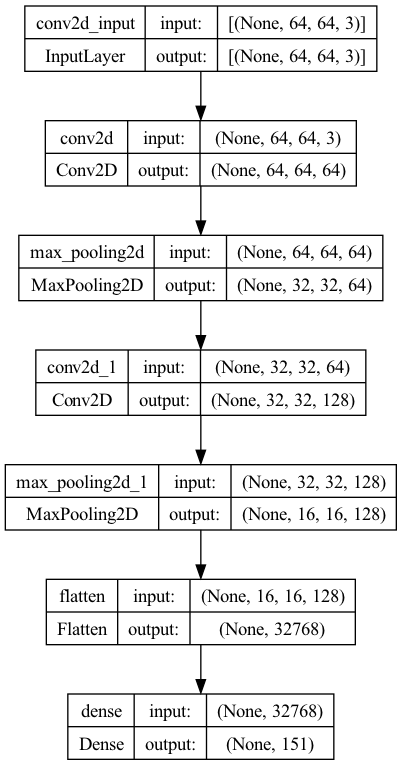

In [15]:
neuralnetwork_cnn = model_1(img_size1, num_classes= 151)
neuralnetwork_cnn.summary()
# Visualizzazione modello Baseline
#tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')
plot_model(neuralnetwork_cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

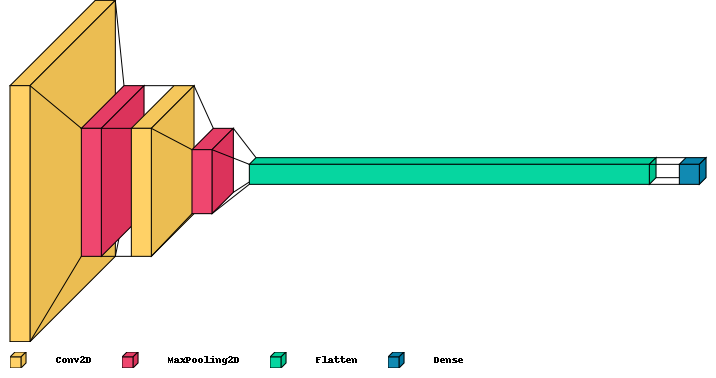

In [16]:
visualkeras.layered_view(neuralnetwork_cnn, legend = True, spacing = 30)

In [26]:
train_set1 , val_set1 = data_load(train_dir = train_dir,
                                  validation_dir = test_dir, 
                                  image_size=img_size1,
                                  num_batch= batch_siz1)

------ Loading TRAIN SET -------
Found 6993 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


In [18]:
hist1 , fil1, es1 = train_model(model=neuralnetwork_cnn, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=5, 
                                num_epochs= 30) # meglio che arrivi a 30

Epoch 1/30


/var/folders/m9/pqjzxxq91zq6tyyywn2gnx740000gn/T/ipykernel_46287/1839661033.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,
2023-08-20 13:29:19.724416: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


219/219 [==============================] - ETA: 0s - loss: 4.2792 - acc: 0.1010
Epoch 1: loss improved from inf to 4.27916, saving model to model5.h5
219/219 [==============================] - 21s 96ms/step - loss: 4.2792 - acc: 0.1010 - val_loss: 3.2067 - val_acc: 0.2475 - lr: 0.0010
Epoch 2/30
219/219 [==============================] - ETA: 0s - loss: 2.7446 - acc: 0.3571
Epoch 2: loss improved from 4.27916 to 2.74459, saving model to model5.h5
219/219 [==============================] - 20s 92ms/step - loss: 2.7446 - acc: 0.3571 - val_loss: 2.1645 - val_acc: 0.5058 - lr: 0.0010
Epoch 3/30
219/219 [==============================] - ETA: 0s - loss: 1.9931 - acc: 0.5097
Epoch 3: loss improved from 2.74459 to 1.99315, saving model to model5.h5
219/219 [==============================] - 20s 93ms/step - loss: 1.9931 - acc: 0.5097 - val_loss: 1.7373 - val_acc: 0.5836 - lr: 0.0010
Epoch 4/30
219/219 [==============================] - ETA: 0s - loss: 1.5685 - acc: 0.6055
Epoch 4: loss improve

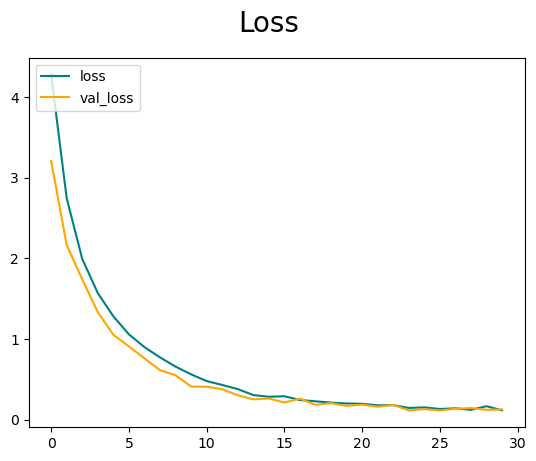

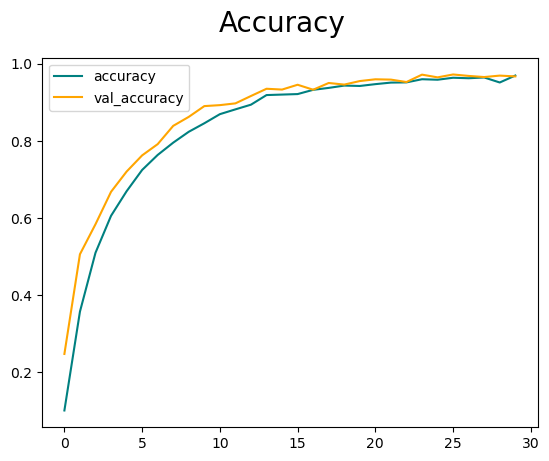

In [19]:
plot_history(hist=hist1)

1/1 [==============================] - 0s 47ms/step


'Pikachu'

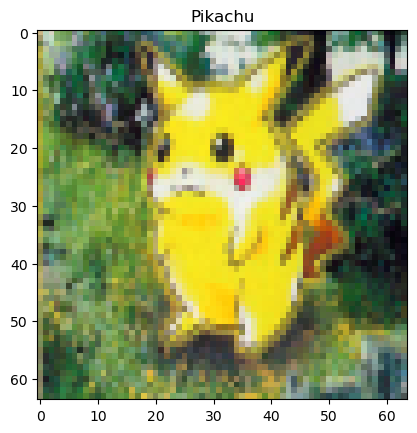

In [43]:
testing(model= 'model3.h5',
        train_set = train_set1, 
        scale= (64,64),
        test_file= 'Pikachu.png')

## Training Model 2

In [16]:
img_size2 = (128, 128, 3)
batch_siz2 = 32
num_classes = 151

In [17]:
train_set2 , val_set2 = data_load(train_dir = train_dir,
                                validation_dir = test_dir, 
                                image_size=img_size2,
                                num_batch= batch_siz2)

------ Loading TRAIN SET -------
Found 6993 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

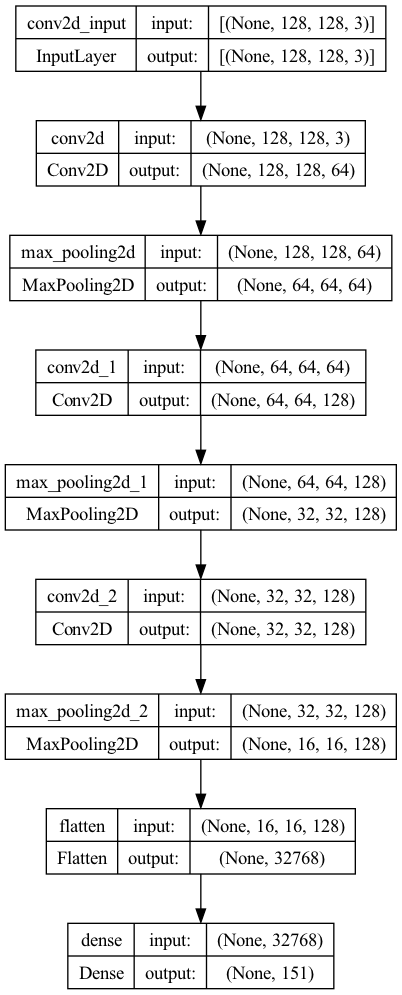

In [18]:
neuralnetwork_cnn2 = model_2(img_size2, num_classes= 151)
neuralnetwork_cnn2.summary()
# Visualizzazione modello Baseline
#tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')
plot_model(neuralnetwork_cnn2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
hist2 , fil2, es2 = train_model(model=neuralnetwork_cnn2, 
                                train_set= train_set2, 
                                val_set= val_set2, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=4, 
                                num_epochs=20)

/var/folders/m9/pqjzxxq91zq6tyyywn2gnx740000gn/T/ipykernel_48117/1839661033.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/20


2023-08-31 10:11:23.389603: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


219/219 [==============================] - ETA: 0s - loss: 4.5389 - acc: 0.0533
Epoch 1: loss improved from inf to 4.53892, saving model to model4.h5
219/219 [==============================] - 43s 181ms/step - loss: 4.5389 - acc: 0.0533 - val_loss: 3.9929 - val_acc: 0.1044 - lr: 0.0010
Epoch 2/20
219/219 [==============================] - ETA: 0s - loss: 3.5574 - acc: 0.2162
Epoch 2: loss improved from 4.53892 to 3.55744, saving model to model4.h5
219/219 [==============================] - 38s 171ms/step - loss: 3.5574 - acc: 0.2162 - val_loss: 3.1280 - val_acc: 0.2849 - lr: 0.0010
Epoch 3/20
219/219 [==============================] - ETA: 0s - loss: 2.7671 - acc: 0.3634
Epoch 3: loss improved from 3.55744 to 2.76710, saving model to model4.h5
219/219 [==============================] - 37s 168ms/step - loss: 2.7671 - acc: 0.3634 - val_loss: 2.3081 - val_acc: 0.4655 - lr: 0.0010
Epoch 4/20
219/219 [==============================] - ETA: 0s - loss: 2.2458 - acc: 0.4645
Epoch 4: loss impr

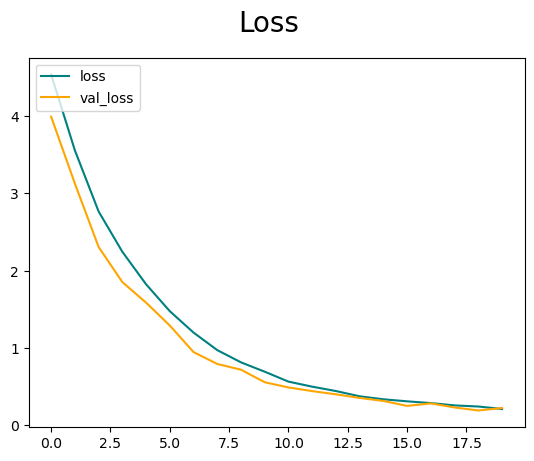

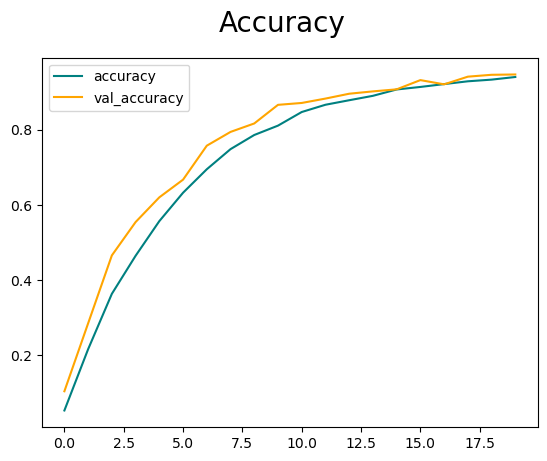

In [20]:
plot_history(hist=hist2)

1/1 [==============================] - 0s 67ms/step


'Pikachu'

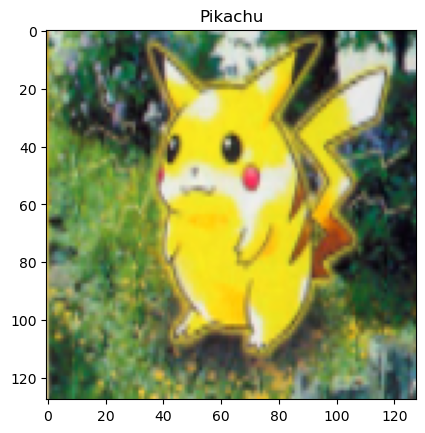

In [40]:
testing(model= 'model4.h5',
        train_set = train_set2, 
        scale= (128,128),
        test_file= 'Pikachu.png')